# Step1資料準備

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
(x_train_10,y_train_10),(x_test_10,y_test_10)=cifar10.load_data()
y_train_10 = to_categorical(y_train_10)
y_test_10 = to_categorical(y_test_10)


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
from tensorflow.keras.layers import Lambda, Dropout,Input, Activation, Dense, GlobalAveragePooling2D, Conv2D,Add, BatchNormalization,DepthwiseConv2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import optimizers,regularizers
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import Callback,LearningRateScheduler, TensorBoard, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
import Model_mobilenet
from Model_mobilenet import MobileNet

In [8]:
MobileNet

<function Model_mobilenet.MobileNet(img_input, shallow=False, classes=10)>

In [3]:
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


### 建立teacher model


In [10]:
img_input=Input(shape=(32,32,3))
output = MobileNet(img_input)
teacher_model = Model(img_input,output)
teacher_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 24)        672       
_________________________________________________________________
batch_normalization_27 (Batc (None, 16, 16, 24)        96        
_________________________________________________________________
activation_27 (Activation)   (None, 16, 16, 24)        0         
_________________________________________________________________
depthwise_conv2d_13 (Depthwi (None, 16, 16, 24)        240       
_________________________________________________________________
batch_normalization_28 (Batc (None, 16, 16, 24)        96        
_________________________________________________________________
activation_28 (Activation)   (None, 16, 16, 24)        0   

In [11]:
batch_size = 64
steps_per_epoch = y_train_10.shape[0] // batch_size
validation_steps = x_test_10.shape[0] // batch_size

log_dir = 'logs/softlabel/teacher/'

checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

teacher_model.compile(loss = "categorical_crossentropy",optimizer = "adam", metrics = ["accuracy"])
train_gen = ImageDataGenerator(rescale = 1./255.).flow(x_train_10,y_train_10, batch_size)
val_gen = ImageDataGenerator(rescale = 1./255.).flow(x_test_10,y_test_10, batch_size)

In [12]:
history = teacher_model.fit_generator(train_gen,
                                      initial_epoch=0,
                                      epochs=50,
                                      steps_per_epoch = steps_per_epoch,
                          validation_data = val_gen, validation_steps = validation_steps,
                          callbacks=[checkpoint, reduce_lr, early_stopping])



Epoch 1/50
781/781 [==============================] - 87s 111ms/step - loss: 1.8918 - accuracy: 0.3120 - val_loss: 1.7163 - val_accuracy: 0.3702 4:03 - loss: 2.6308 - accuracy: 0.10 - ETA: 3:39 - loss: 2.6048 - accuracy: 0. - ETA: 3:07 - loss: - ETA: 2:00 -  - ETA: 58s - loss: 2.1756 -  - ETA: 56s - loss: 2.1623 - accuracy: 0.21 - ETA: 56s - loss: 2.1605 - accuracy: 0. - ETA: 56s - loss: 2.1575 - accuracy:  - ETA: 50s - loss: 2.1176 - accuracy - ETA: 49s - loss: 2.1091 - accura - ETA: 48s - loss: 2.1028 - accura - ETA: 47s - loss: 2.0956 - accuracy: 0.240 - ETA: 47s - loss:   - ETA: 39s - loss: 2.0503 - accuracy:  - ETA: 38s - loss: 2.0463 - acc - ETA: 37s - loss: 2.0383 - accuracy: 0 - ETA: 37s - loss: 2.0365 - accuracy: - ETA: 36s - loss: 2.0337 - accuracy: 0.2 - ETA: 36s - loss: 2.032 - ETA: 33s - loss: 2.0216 - accuracy: 0.26 - ETA: 33s - loss: 2.0208 - accuracy:  - ETA: 33s - loss: 2.0164 - accuracy: 0.26 - ETA: 32s - loss: - ETA: 30s - loss: 2.0027 - accur - ETA: 29s - loss: 1.99

781/781 [==============================] - 83s 106ms/step - loss: 0.8340 - accuracy: 0.7134 - val_loss: 1.2406 - val_accuracy: 0.62164 - loss: - ETA: 1:12 - loss: 0.8069 - accuracy: 0.71 - ETA: 1:12 - loss: - ETA: 1:11 - loss: 0.8098 - accuracy:  - ETA: 1:11 - loss: 0.8014 - accuracy:  - ETA: 1:10 - loss: 0.8035 - accuracy - ETA: 1:10 - loss: 0.8100 - accura - ETA: 1:10 - loss: 0.8016 - accuracy: 0. - ETA: 1:09 - loss: 0.7973 - accura - ETA: 1:09 - loss: 0.8000 -  - ETA: 1:06 - loss: 0 - ETA: 1:05 - loss: 0.7885 - accura - ETA: 1:04 - - ETA: 1:00 - loss - ETA: 59s - loss: 0.7929 - accuracy: 0 - ETA: 58s - loss: 0.7912 - accuracy:  - ETA: 58s - loss: 0.7896 - accuracy: 0. - ETA: 57s - loss: 0.7929 -  - ETA: 56s - loss: 0.7970 - accuracy - ETA: 55s - loss: 0.7992 - accuracy: 0 - ETA: 54s - loss: - ETA: 52s - loss: 0.7995 - accuracy:  - ETA: 51s - loss: 0.8013 - accuracy: 0.72 - ETA: 51s - loss: 0 - ETA: 49s - loss: 0.8061 - a - ETA: 47s - loss:  - ETA: 45s - loss: 0.8053 - accuracy: 0 - 

781/781 [==============================] - 83s 106ms/step - loss: 0.2866 - accuracy: 0.9020 - val_loss: 0.9212 - val_accuracy: 0.7317ss: 0.2 - ETA: 1:14 - loss: 0.2888 - accuracy:  - ETA:  - - ETA: 1:02 - loss: 0.2939 - ac - ETA: 1:02 - loss: 0.2940 - accuracy: 0. - ETA: 1:01 - loss: 0.2939 - accuracy - ETA: 1:01 - loss: 0.2956 - accuracy: 0. - ETA: 1:01 - loss: 0.2954 - accuracy:  - ETA: 1:00 - loss: 0.2952 -  - ETA: 1:00 - loss: 0.2951 - accuracy: - ETA: 59s - loss: 0.2939 - accura - ETA: 58s - loss: 0.2949 - accuracy: 0.900 - ETA: 58s - loss: 0.2945 - accuracy: 0.9 - ETA: 58s - los - ETA: 55s - loss - ETA: 52s - loss: 0 - ETA: 46s - loss: 0.2939 - accuracy: 0.90 - ETA: 46s - loss: 0.2952 - a - ETA: 44s - loss: 0.2958 - accuracy: 0.89 - ETA: 44s - loss: 0.2948 - accura - ETA: 43s - loss: 0.2940 - accuracy: 0.9 - ETA: 43s - loss: 0.2931 - accuracy: 0. - ETA: 42s - loss - ETA: 35s - loss: 0.2932 - ETA: 33s - loss: 0.2921 - ac - ETA: 32s - loss: 0.29 - ETA: 30s - loss: 0.290 - ETA: 28s 

In [ ]:
teacher_model.save('teacher_model_624.h5')

history.history.keys()
teacher = pd.DataFrame(history.history, index=range(1,len(history.history['loss'])+1))
teacher.to_csv('E:/NCHU_PHD/10902sml/report2/final_624/teacher.CSV')

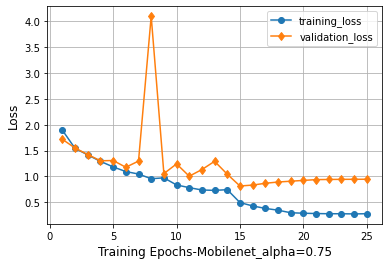

In [14]:
from matplotlib import pyplot as plt
plt.plot(teacher['loss'], marker='o', label='training_loss')
plt.plot(teacher['val_loss'], marker='d', label='validation_loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Training Epochs-Mobilenet_alpha=0.75', fontsize=12)
plt.grid()
plt.legend()

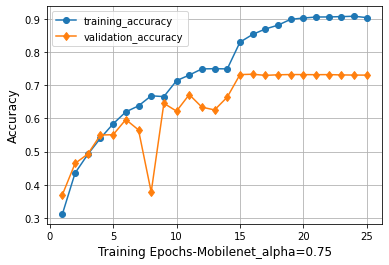

In [15]:
plt.plot(teacher['accuracy'], marker='o', label='training_accuracy')
plt.plot(teacher['val_accuracy'], marker='d', label='validation_accuracy')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Training Epochs-Mobilenet_alpha=0.75', fontsize=12)
plt.grid()
plt.legend()

### unlabel data讀取,標籤,篩選

In [16]:
img_path = r"E:\NCHU_PHD\10902sml\data_set\add"
img_list = os.listdir(img_path)

x_train_imgnet = []

for i in img_list:
    abs_path = os.path.join(img_path, i)
    temp = load_img(abs_path)
    temp = img_to_array(temp)
    x_train_imgnet.append(temp)

x_train_imgnet = np.array(x_train_imgnet)

batch_size = 40
step = int(x_train_imgnet.shape[0] / batch_size)
print(step)

y_train_imgnet_dummy = []

for i in range(step):
    x_temp = x_train_imgnet[batch_size*i:batch_size*(i+1)]
    x_temp = x_temp / 255.
    temp = teacher_model.predict(x_temp)
    y_train_imgnet_dummy.extend(temp)

y_train_imgnet_dummy = np.array(y_train_imgnet_dummy)

#np.save('y_train_imgnet_dummy',y_train_imgnet_dummy)


threhold = 0.3
y_train_imgnet_dummy_th =  y_train_imgnet_dummy[np.max(y_train_imgnet_dummy, axis=1) > threhold]
x_train_imgnet_th = x_train_imgnet[np.max(y_train_imgnet_dummy, axis=1) > threhold]

### 挑出confindence score > 0.3的圖片總共有  18354 張

### 將label data 與unlabel data合併

####用list包

temp_l_tile.shape

y_student_all_dummy_label = np.argmax(y_train_imgnet_dummy_th, axis=1)

u, counts = np.unique(y_student_all_dummy_label, return_counts=True)
print(u, counts)

student_label_max =  max(counts)

y_student_per_label = []
y_student_per_img_path = []

for i in range(10):
    temp_l = y_train_imgnet_dummy_th[y_student_all_dummy_label == i]
    print(i, ":", temp_l.shape)
    y_student_per_label.append(temp_l)
    temp_i = x_train_imgnet_th[y_student_all_dummy_label == i]
    print(i, ":", temp_i.shape)
    y_student_per_img_path.append(temp_i)

y_student_per_label_add = []
y_student_per_img_add = []

for i in range(10):
    num = y_student_per_label[i].shape[0]
    temp_l = y_student_per_label[i]
    temp_i = y_student_per_img_path[i]
    add_num = student_label_max - num
    q, mod = divmod(add_num, num)
    print(q, mod)
    temp_l_tile = np.tile(temp_l, (q+1, 1))
    temp_i_tile = np.tile(temp_i, (q+1, 1, 1, 1))
    temp_l_add = temp_l[:mod]
    temp_i_add = temp_i[:mod]
    temp_l_new = np.concatenate([temp_l_tile, temp_l_add], axis=0)

    temp_i_new = np.concatenate([temp_i_tile, temp_i_add], axis=0)

    p = (-temp_l_new[:,0]).argsort()
    temp_l_new = temp_l_new[p]
    temp_i_new= temp_i_new[p]
    y_student_per_label_add.append(temp_l_new[:7000])
    y_student_per_img_add.append(temp_i_new[:7000])

print([len(i) for i in y_student_per_label_add])

student_train_img = np.concatenate(y_student_per_img_add, axis=0)
student_train_label = np.concatenate(y_student_per_label_add, axis=0)

x_train_student = np.concatenate([x_train_10, student_train_img], axis=0)
y_train_student = np.concatenate([y_train_10, student_train_label], axis=0)


In [98]:
np.save('x_train_student',x_train_student)
np.save('y_train_student',y_train_student)

In [25]:
##load 重新標籤完的dataset
#x_train_student=np.load('x_1.npy')
#y_train_student=np.load('y_1.npy')

### Student_model_1的訓練資料量總共有120000張

In [99]:
x_train_student.shape

(120000, 32, 32, 3)

In [5]:
teacher_model = teacher_model = load_model('teacher_model_624.h5')


In [6]:
###test
img_path = "E:/NCHU_PHD/10902sml/data_set/add_test"
img_list = os.listdir(img_path)

x_test = []
y_test = []

for i in img_list:
    img_list_= img_path +"/"+i
    for j in os.listdir(img_list_):
        abs_path = img_path +"/"+i +"/"+j
        temp = load_img(abs_path)
        temp = img_to_array(temp)
        x_test.append(temp)
        y_test.append(i)
    
x_test = np.array(x_test)
y_test = np.array(y_test).reshape((500, 1))
y_test = to_categorical(y_test)

def my_eval(model,x,t):
    ev = model.evaluate(x,t, batch_size=10)
    print("loss:"+str(round(ev[0],4)))
    print("acc: "+str(ev[1]))

my_eval(teacher_model,x_test/255,y_test)

500/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

loss:2.1933
acc: 0.52
